In [1]:
#install library tensorflow
!pip3 install tensorflow

You should consider upgrading via the 'c:\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#install library keras
!pip3 install keras

You should consider upgrading via the 'c:\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
#import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import math
import os.path
import seaborn as sns
from keras.models import Sequential  
from keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from zipfile import ZipFile 
from sklearn import metrics

# 10 Monkey Species

### [Training Dataset](https://drive.google.com/file/d/10Bbf1I0exU7UzbqHBlwB8OAVGNxHaC_B/view?usp=sharing)

### [Validation Dataset](https://drive.google.com/file/d/1qg13fgVPqj_UVjvVhR-1WES_hriaRJFG/view?usp=sharing)

In [4]:
#specifying the zip file name
train_file = 'training.zip'
  
#opening the zip file in READ mode
with ZipFile(train_file, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
training/n0/                                   2018-01-21 15:20:00            0
training/n0/n0018.jpg                          2006-04-13 19:35:56        38525
training/n0/n0019.jpg                          2018-01-05 13:45:36       219701
training/n0/n0020.jpg                          2017-02-12 08:20:50        53734
training/n0/n0021.jpg                          2014-07-21 09:25:56      9072692
training/n0/n0022.jpg                          2013-10-06 00:02:34       993829
training/n0/n0023.jpg                          2016-10-17 07:14:54        98814
training/n0/n0024.jpg                          2016-02-20 00:10:20       151884
training/n0/n0025.jpg                          2013-10-04 10:18:22      2224509
training/n0/n0026.jpg                          2012-08-17 20:42:08        75371
training/n0/n0027.jpg                          2010-01-01 14:00:00       141561
training/n0/n0028.jpg                   

In [5]:
#specifying the zip file name
validation_file = 'validation.zip'
  
#opening the zip file in READ mode
with ZipFile(validation_file, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
validation/n0/                                 2018-01-21 15:19:20            0
validation/n0/n000.jpg                         2016-10-17 07:14:54        67803
validation/n0/n001.jpg                         2014-04-07 22:46:14        72122
validation/n0/n0010.jpg                        2018-01-02 20:26:42       413936
validation/n0/n0011.jpg                        2016-10-17 07:14:54       105527
validation/n0/n0012.jpg                        2014-07-21 09:25:58     11620068
validation/n0/n0013.jpg                        2012-06-27 16:33:52       108397
validation/n0/n0014.jpg                        2013-09-25 10:49:02       141787
validation/n0/n0015.jpg                        2013-12-15 18:40:14       501801
validation/n0/n0016.jpg                        2013-10-05 09:43:26      2165549
validation/n0/n0017.jpg                        2017-07-19 08:18:12        59152
validation/n0/n002.jpg                  

## Exploratory Data Analysis (EDA)

In [6]:
#create a list with the filepaths
train_dir = Path('training')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_dir = Path('validation')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
#define function for processing image files
def proc_img(filepath):
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
    filepath = pd.Series(filepath, name = 'Filepath').astype(str)
    labels = pd.Series(labels, name = 'Label')
    df = pd.concat([filepath, labels], axis = 1)
    df = df.sample(frac = 1).reset_index(drop = True)
    return df

#create a dataframe with the filepaths and the labels of the picture
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

#the DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 1096

Number of different labels: 10

Labels: ['n4' 'n2' 'n1' 'n9' 'n0' 'n8' 'n3' 'n6' 'n7' 'n5']


,Filepath,Label
0,training\n4\n4151.jpg,n4
1,training\n2\n2151.jpg,n2
2,training\n1\n1165.jpg,n1
3,training\n9\n9127.jpg,n9
4,training\n4\n41559.jpg,n4


In [8]:
#mapping label images
name_dic = {'n0':'Alouatta Palliata', 
            'n1':'Erythrocebus Patas', 
            'n2':'Cacajao Calvus', 
            'n3':'Macaca Fuscata', 
            'n4':'Cebuella Pygmea', 
            'n5':'Cebus Capucinus', 
            'n6':'Mico Argentatus', 
            'n7':'Saimiris Ciureus', 
            'n8':'Aotus Nigriceps', 
            'n9':'Trachypithecus Johnii'}

#mapping the label images into the DataFrame
train_df['Label'] = train_df['Label'].apply(lambda n: name_dic[n])
test_df['Label'] = test_df['Label'].apply(lambda n: name_dic[n])
print('Training : \n', train_df)
print('Testing : \n', test_df)

Training : 
                     Filepath                  Label
0      training\n4\n4151.jpg        Cebuella Pygmea
1      training\n2\n2151.jpg         Cacajao Calvus
2      training\n1\n1165.jpg     Erythrocebus Patas
3      training\n9\n9127.jpg  Trachypithecus Johnii
4     training\n4\n41559.jpg        Cebuella Pygmea
...                      ...                    ...
1091   training\n6\n6149.jpg        Mico Argentatus
1092   training\n5\n5046.jpg        Cebus Capucinus
1093   training\n8\n8046.jpg        Aotus Nigriceps
1094   training\n8\n8136.jpg        Aotus Nigriceps
1095   training\n4\n4033.jpg        Cebuella Pygmea

[1096 rows x 2 columns]
Testing : 
                     Filepath               Label
0     validation\n5\n516.jpg     Cebus Capucinus
1     validation\n2\n209.jpg      Cacajao Calvus
2     validation\n6\n613.jpg     Mico Argentatus
3    validation\n3\n3017.jpg      Macaca Fuscata
4     validation\n8\n813.jpg     Aotus Nigriceps
..                       ...    

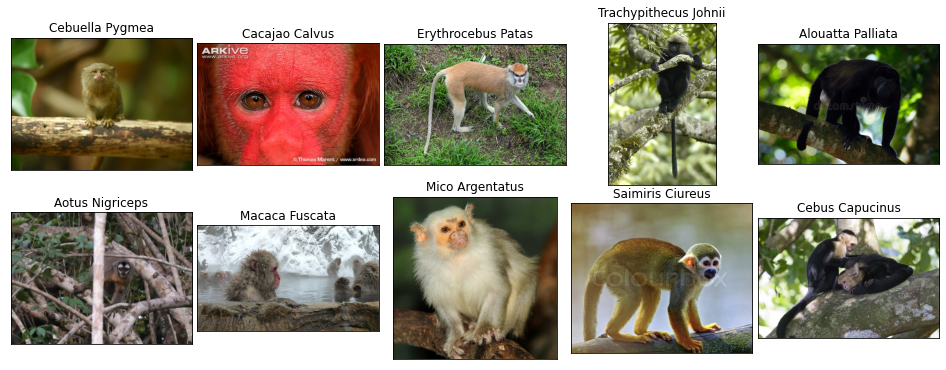

In [9]:
#create a dataframe with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset = ['Label']).reset_index()

#display 10 picture of the dataset
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (13,5), subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i])
    
plt.tight_layout(pad = 0.2)
plt.show()

In [10]:
#generate training image for processing using keras
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = 
                                                                  tf.keras.applications.mobilenet_v2.preprocess_input, 
                                                                  validation_split = 0.2)

#generate testing image for processing using keras
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = 
                                                                 tf.keras.applications.mobilenet_v2.preprocess_input)

#create dataframe for result of train images processing
train_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col = 'Filepath', y_col = 'Label', 
                                                   target_size = (224, 224), color_mode = 'rgb', class_mode = 'categorical', 
                                                   batch_size = 32, shuffle = True, seed = 0, subset = 'training', 
                                                   rotation_range = 30, zoom_range = 0.15, width_shift_range = 0.2, 
                                                   height_shift_range = 0.2, shear_range = 0.15, horizontal_flip = True, 
                                                   fill_mode = 'nearest')

val_images = train_generator.flow_from_dataframe(dataframe = train_df, x_col = 'Filepath', y_col = 'Label', 
                                                 target_size = (224, 224), color_mode = 'rgb', class_mode = 'categorical', 
                                                 batch_size = 32, shuffle = True, seed = 0, subset = 'validation', 
                                                 rotation_range = 30, zoom_range = 0.15, width_shift_range = 0.2, 
                                                 height_shift_range = 0.2, shear_range = 0.15, horizontal_flip = True, 
                                                 fill_mode = 'nearest')

#create dataframe for result of test images processing
test_images = test_generator.flow_from_dataframe(dataframe = test_df, x_col = 'Filepath', y_col = 'Label', 
                                                 target_size = (224, 224), color_mode = 'rgb', class_mode = 'categorical', 
                                                 batch_size = 32, shuffle = False)

Found 877 validated image filenames belonging to 10 classes.
Found 219 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


## Convolutional Neural Network (CNN)

In [11]:
#load the pretained model (Convolutional Neural Network)
pretrained_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet', 
                                                     pooling = 'avg')
pretrained_model.trainable = False
print(pretrained_model)

In [12]:
#implementation model in training data with linear activation
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation = 'linear')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation = 'linear')(x)

outputs = tf.keras.layers.Dense(10, activation = 'softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#fitting model from 20 epochs 
history = model.fit(train_images, validation_data = val_images, epochs = 20, callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 3, restore_best_weights = True)])

Epoch 1/20
28/28 [==============================] - 54s 2s/step - loss: 0.5301 - accuracy: 0.8461 - val_loss: 0.0911 - val_accuracy: 0.9726
Epoch 2/20
28/28 [==============================] - 35s 1s/step - loss: 0.0247 - accuracy: 0.9954 - val_loss: 0.0334 - val_accuracy: 0.9954
Epoch 3/20
28/28 [==============================] - 35s 1s/step - loss: 0.0097 - accuracy: 0.9989 - val_loss: 0.0433 - val_accuracy: 0.9909
Epoch 4/20
28/28 [==============================] - 34s 1s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9954
Epoch 5/20
28/28 [==============================] - 36s 1s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0317 - val_accuracy: 0.9954
Epoch 6/20
28/28 [==============================] - 33s 1s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9954
Epoch 7/20
28/28 [==============================] - 35s 1s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9954
Epoch 8/20
28/28 [==

## Evaluation

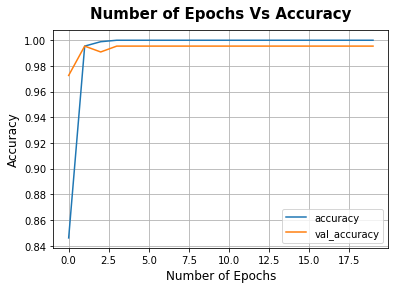

In [13]:
#create dataframe for visualize number of epochs to accuracy 
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Number of Epochs Vs Accuracy', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Number of Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.grid(True)
plt.show()

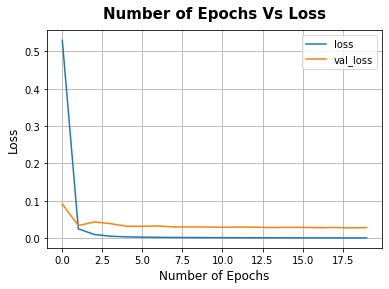

In [14]:
#create dataframe for visualize number of epochs to loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Number of Epochs Vs Loss', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Number of Epochs', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.grid(True)
plt.show()

In [15]:
#predict the label of the test images
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis = 1)

#mapping the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in y_pred]

#display the result
print(f'The first 5 image predictions: {y_pred[:5]}')

The first 5 image predictions: [4 2 7 6 1]


In [16]:
#check accuracy score
y_test = list(test_df.Label)
score = metrics.accuracy_score(y_test, pred)
print(f'Accuracy Score : {score * 100:.2f} %')

Accuracy Score : 98.16 %


In [17]:
#check classification report
report = metrics.classification_report(y_test, pred, zero_division = 1)
print('Classification Report of Convolutional Neural Network : \n')
print(report)

Classification Report of Convolutional Neural Network : 

                       precision    recall  f1-score   support

    Alouatta Palliata       0.93      1.00      0.96        26
      Aotus Nigriceps       1.00      0.96      0.98        27
       Cacajao Calvus       1.00      0.96      0.98        27
      Cebuella Pygmea       0.96      0.96      0.96        26
      Cebus Capucinus       1.00      1.00      1.00        28
   Erythrocebus Patas       1.00      1.00      1.00        28
       Macaca Fuscata       1.00      1.00      1.00        30
      Mico Argentatus       0.96      1.00      0.98        26
     Saimiris Ciureus       0.97      1.00      0.98        28
Trachypithecus Johnii       1.00      0.92      0.96        26

             accuracy                           0.98       272
            macro avg       0.98      0.98      0.98       272
         weighted avg       0.98      0.98      0.98       272



[[26  0  0  0  0  0  0  0  0  0]
 [ 0 26  0  0  0  0  0  0  1  0]
 [ 0  0 26  0  0  0  0  1  0  0]
 [ 1  0  0 25  0  0  0  0  0  0]
 [ 0  0  0  0 28  0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 0  0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  0  0 28  0]
 [ 1  0  0  1  0  0  0  0  0 24]]


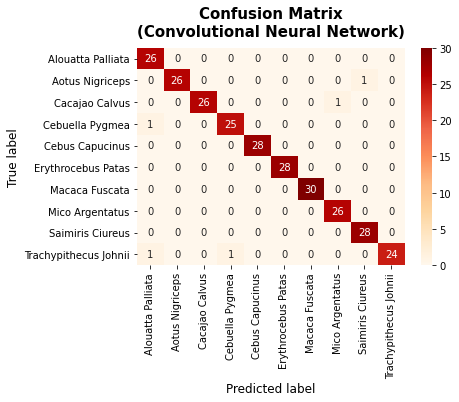

In [18]:
#evaluation of confusion matrix
matrix = metrics.confusion_matrix(y_test, pred)
print(matrix)

#visualize confusion matrix
sns.heatmap(matrix, annot = True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), cmap = 'OrRd')
plt.title('Confusion Matrix\n(Convolutional Neural Network)', fontsize = 15, pad = 12, fontweight = 'bold')
plt.ylabel('True label', fontsize = 12)
plt.xlabel('Predicted label', fontsize = 12)
plt.show()

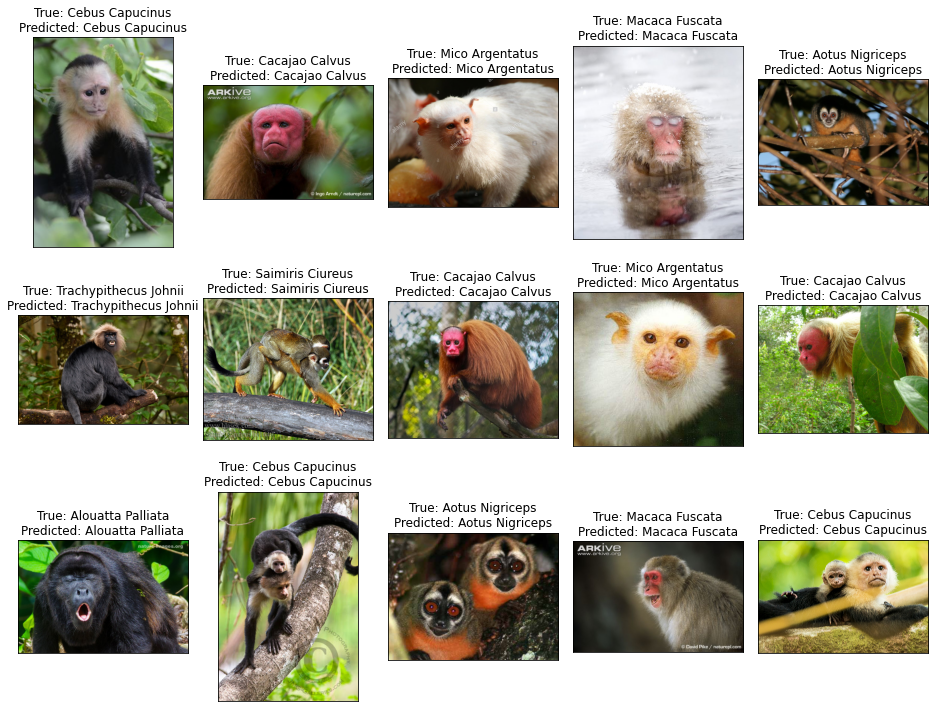

In [19]:
#display 15 picture predictions of the dataset with their labels
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (13, 10), subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")

plt.tight_layout()
plt.show()

# Google Stock Price

In [20]:
#load dataset
df_google = pd.read_csv('Google_Stock_Price_Train.csv')

In [21]:
#show head of dataset
df_google.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


## Exploratory Data Analysis (EDA)

In [22]:
#check total rows and columns
df_google.shape

(1258, 6)

In [23]:
#check missing value
df_google.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [24]:
#check dataset types
df_google.dtypes 

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

In [25]:
#transform date column to datetime
df_google['Date'] = pd.to_datetime(df_google['Date'], format = '%m/%d/%Y')
df_google = df_google.set_index('Date')
df_google.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)

In [26]:
#transform close and volume column to float type
for i in df_google[['Close', 'Volume']]:
    df_google[i] = [float(str(i).replace(',', '')) for i in df_google[i]]

df_google.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [27]:
#describe dataset
df_google.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,533.709833,537.880223,529.007409,712.669666,3.158107e+06
std,151.904442,153.008811,150.552807,164.752591,2.273726e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,816.680000,816.680000,805.140000,1216.830000,2.497790e+07


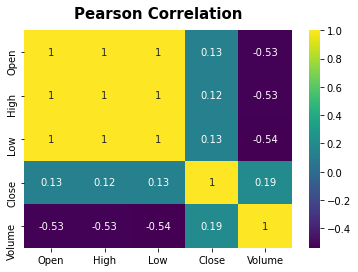

In [28]:
#visualize correlation of each numerical variable using pearson correlation
sns.heatmap(df_google.corr(), annot = True, cmap = 'viridis')
plt.title('Pearson Correlation', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

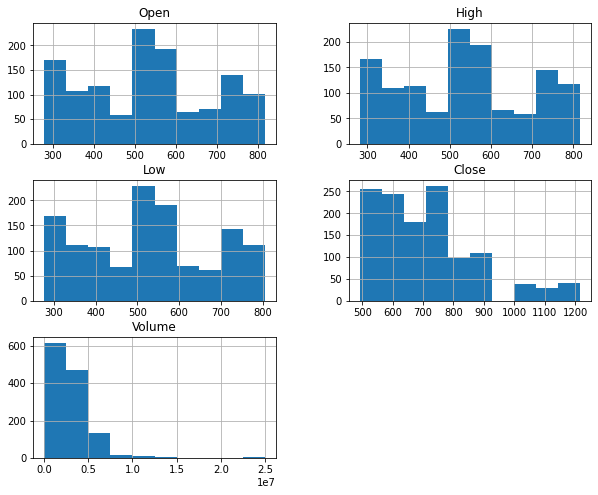

In [29]:
#visualize all distribution of dataset
df_google.hist(figsize = (10,8))
plt.show()

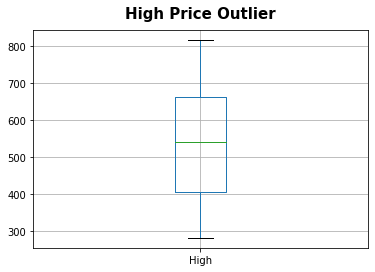

Maximum of High Price : 816.68
Median of High Price : 540.75
Minimum of High Price : 281.21


In [30]:
#check outlier of high price
df_google.boxplot(column = 'High')
plt.title('High Price Outlier', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

print('Maximum of High Price :', df_google['High'].max())
print('Median of High Price :', df_google['High'].median())
print('Minimum of High Price :', df_google['High'].min())

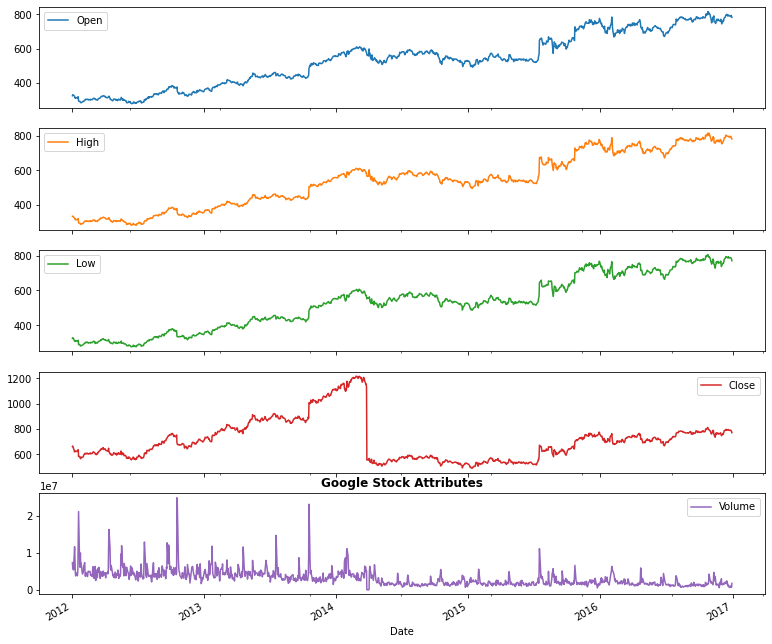

In [31]:
#visualize of each attribute columns
df_google['2012':'2016'].plot(subplots = True, figsize = (13,12))
plt.title('Google Stock Attributes', fontweight = 'bold')
plt.show()

## Reccurent Neural Network (RNN) 

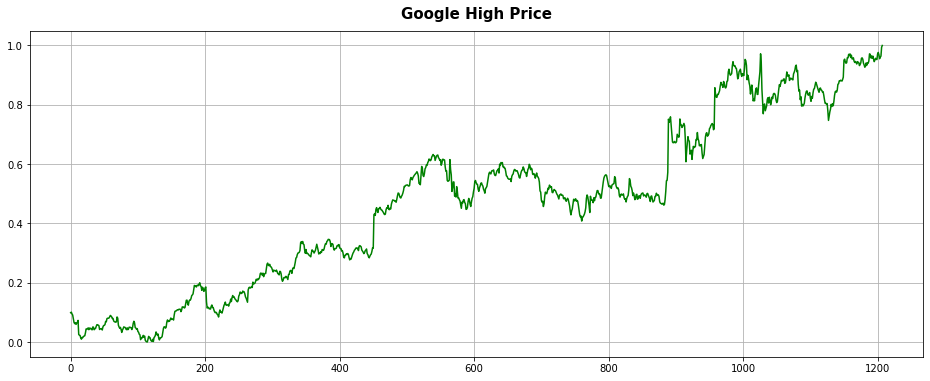

In [32]:
#create variable to frame high price column
df_high = df_google.loc[:, ['High']].values

#split data
train = df_high[:len(df_high) - 50] 
test = df_high[len(train):]

#reshape
train = train.reshape(train.shape[0], 1)

#feature scaling
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)

#visualize google high price
plt.figure(figsize = (16,6))
plt.plot(train_scaled, color = 'green')
plt.title('Google High Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.grid(True)
plt.show()

In [33]:
#adding first 50 location to X_train and 51 location to y_train
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)

#reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
print(X_train)

[[[0.09862626]
  [0.10061331]
  [0.09465217]
  ...
  [0.04042874]
  [0.0507461 ]
  [0.05544623]]

 [[0.10061331]
  [0.09465217]
  [0.09086914]
  ...
  [0.0507461 ]
  [0.05544623]
  [0.05613405]]

 [[0.09465217]
  [0.09086914]
  [0.07848832]
  ...
  [0.05544623]
  [0.05613405]
  [0.05842679]]

 ...

 [[0.95880701]
  [0.95802365]
  [0.97007967]
  ...
  [0.96853207]
  [0.95532968]
  [0.96054567]]

 [[0.95802365]
  [0.97007967]
  [0.96601005]
  ...
  [0.95532968]
  [0.96054567]
  [0.96417585]]

 [[0.97007967]
  [0.96601005]
  [0.97162728]
  ...
  [0.96054567]
  [0.96417585]
  [0.99428724]]]


In [34]:
#initialising the RNN
regressor = Sequential()

#adding the first RNN layer and some dropout regularisation
regressor.add(SimpleRNN(units = 100, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

#adding the output layer
regressor.add(Dense(units = 1))

#compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#fitting the RNN to the training set for 20 epochs
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
37/37 [==============================] - 3s 32ms/step - loss: 0.2047
Epoch 2/20
37/37 [==============================] - 1s 32ms/step - loss: 0.0426
Epoch 3/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0278
Epoch 4/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0210
Epoch 5/20
37/37 [==============================] - 1s 32ms/step - loss: 0.0176
Epoch 6/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0143
Epoch 7/20
37/37 [==============================] - 1s 32ms/step - loss: 0.0121
Epoch 8/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0109
Epoch 9/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0095
Epoch 10/20
37/37 [==============================] - 1s 32ms/step - loss: 0.0094
Epoch 11/20
37/37 [==============================] - 1s 32ms/step - loss: 0.0086
Epoch 12/20
37/37 [==============================] - 1s 31ms/step - loss: 0.0077
Epoch 13/20
37/37 [==================

## Evaluation

In [35]:
#summary of model
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           10200     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________


In [36]:
#feature scaling for prediction
inputs = df_high[len(df_high) - len(test) - timesteps:]
inputs = scaler.transform(inputs) 

X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i - timesteps:i, 0]) 
    
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#prediction
y_pred = regressor.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred)

[[789.1839 ]
 [785.61456]
 [786.5433 ]
 [789.9804 ]
 [797.     ]
 [791.06305]
 [792.49316]
 [790.1788 ]
 [790.0863 ]
 [778.2978 ]
 [774.5545 ]
 [756.3427 ]
 [768.6966 ]
 [765.96265]
 [775.6851 ]
 [776.06744]
 [783.7024 ]
 [764.2378 ]
 [749.6597 ]
 [751.1978 ]
 [755.58496]
 [759.8718 ]
 [761.6819 ]
 [760.44385]
 [759.0951 ]
 [755.9674 ]
 [751.41296]
 [762.5184 ]
 [754.6612 ]
 [762.2457 ]
 [755.38763]
 [747.77344]
 [749.16125]
 [754.3921 ]
 [755.3814 ]
 [763.4403 ]
 [765.545  ]
 [777.08057]
 [783.12213]
 [783.1525 ]
 [785.60675]
 [785.0942 ]
 [779.1652 ]
 [783.8767 ]
 [780.7841 ]
 [779.31384]
 [777.78357]
 [775.70734]
 [773.82996]
 [775.24603]]


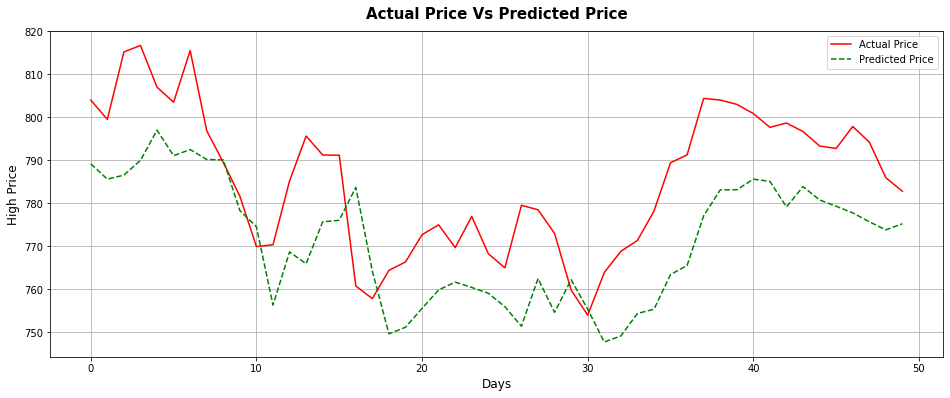

In [37]:
#visualize actual vs prediction of google high price
plt.figure(figsize = (16,6), facecolor = 'w', edgecolor = 'k')
plt.plot(test, color = 'red', label = 'Actual Price')
plt.plot(y_pred, color = 'green', linestyle = 'dashed', label = 'Predicted Price')
plt.title('Actual Price Vs Predicted Price', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('Days', fontsize = 12)
plt.ylabel('High Price', fontsize = 12)
plt.grid(True)
plt.legend()
plt.show()